# Pyladies Meetup Week One: Bayes in Practice

## Meant for an "after work" live presentation
This notebook is meant for a live presentation and may be confusing to follow without direct explanation. It also is a very quick treatment of Bayes Theorem for the mean for the "after work exhausted professional".

If you're interested after this tutorial I would suggest reading

* Bayesian Analysis with Python - Osvaldo Martin
* Statistical Rethinking - Richard McElreath

In [33]:
import pymc3 as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats

## Agenda
1. Bayes Refresher from last week
2. A case of a little data and a lot of data
3. Linear Regression
    * Least Squares Method
    * Bayesian Method
5. Real world example
6. Why's this useful?

## Refresher
Bayesian methods let us 
* Define our own model of how data is generated
* Incorporate prior beliefs
* Estimate uncertainty in our beliefs given data/observations

Last week this is how we did it with our cards data

Number of Red Observations 2, Total Number of Observations 5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_red]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:02<00:00, 7673.00draws/s]


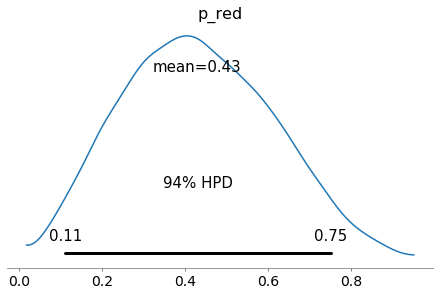

In [19]:
observations = [0, 0, 0, 1, 1]
red_observations = sum(observations)
total_observations = len(observations)
print(f"Number of Red Observations {red_observations}, Total Number of Observations {total_observations}")

with pm.Model() as five_obs_model:
    # Prior
    p_red = pm.Uniform("p_red", 0, 1)
    
    # Likelihood
    num_red = pm.Binomial("number_observed_red", p=p_red, n=total_observations, observed=red_observations)
    trace = pm.sample(draws=5000)
    
az.plot_posterior(trace);

## Linear Regression: The next obligatory statistics example
Let's simulate some linear data. We'll simulate some noise/error that always occurs in real life as well.

In [132]:
np.random.seed(0)
sample_size = 100

# Generate random values between 1 and 50
x = np.random.randint(1, 10, sample_size)

intercept = 10
slope = 2

# Generate y values using out slope and intercept
y= x*slope + intercept

# Add some noise in using a zero centered Gaussian/Normal Distribution
noise = 2
noisy_y = y + stats.norm(0, noise).rvs(sample_size)

x[:10], noisy_y[:10]

(array([6, 1, 4, 4, 8, 4, 6, 3, 5, 8]),
 array([23.44801272, 12.71800553, 20.15224208, 18.38428167, 27.70585192,
        18.03671437, 22.85660713, 17.99255567, 19.01770069, 27.42535633]))

In [135]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x, noisy_y)
slope, intercept, r_value, p_value, std_err

(2.0334236749589443,
 9.92266432757549,
 0.9270782237157019,
 1.5047628425131682e-43,
 0.08305709731417138)

## Standard Linear Regression

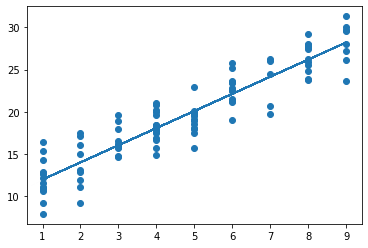

In [137]:
fig, ax = plt.subplots()

# Plot Dots
ax.scatter(x, noisy_y)

# Plot Best Fit Line
_x = np.linspace(0, 20, 1000)
ax.plot(x, x*slope+intercept)

## Bayes Linear Regression

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_estimate, intercept_estimate, slope_estimate]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:05<00:00, 3898.83draws/s]


(<Figure size 432x518.4 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f381ef1cf50>],
       dtype=object))

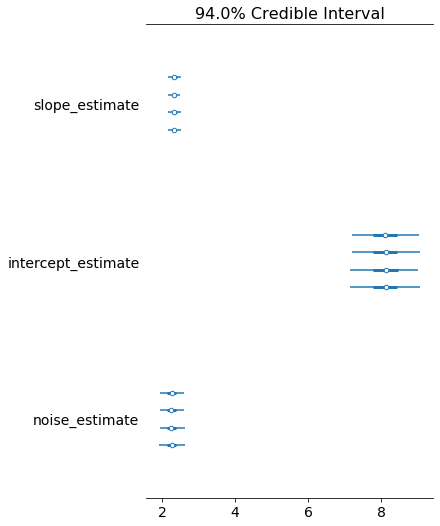

In [138]:
with pm.Model() as linear_model:
    
    slope_estimate = pm.Normal("slope_estimate", 0, 1)
    intercept_estimate = pm.Normal("intercept_estimate", 0, 1)
    
    # Noise is its own parameter
    noise_estimate = pm.HalfNormal("noise_estimate", 5)
    
    # The data follows a mean of y with a known noise
    y_estimate = pm.Normal("y_estimate", slope_estimate*x + intercept_estimate, noise_estimate, observed=noisy_y)
    trace = pm.sample(draws=5000)
    

az.plot_forest(trace)

## World Health Example

## Extra topics we are not covering

### Hierachial Regresions
Bayesian Methods allow for a concept of hierarchial pooling, where multiple subgroups can share inforation from a pooled group. This is a great way to make the most of sparse datasets. A good example of this is Radon Levels in basements, where many counties only have a couple measurements, but overall there are a couple hundred measurements. 

### Generative Modeling
Bayesian Models are generative, meaning you can simulate what future would look like. This can be good if your data is sparse, and you want to see what the next observations might look like

### Decision Analysis
The generative model part becomes really great with decision analysis, which lets you optimize future choices. An example [optimizing the best place to buy material from](http://canyon289.github.io/BayesianDecisionMaking.html#BayesianDecisionMaking)

### You get to work with an amazing group of people making cool open source software to freely share knowledge with the world!!!!
Ok sure this one doesn't look like the others, but really the people I've worked interacted with in the Bayesian community are fantastic. If you're looking to join an open source community I've found no better. Feel free to reach out to me or check out the contributing guide on the repos. Or show up to PyDataLA where we are running open source sprints!